<a href="https://colab.research.google.com/github/gustavo-moretto/WebScrapping_ImoveisCuritiba/blob/main/imoveis_curitiba_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
class database_imoveis():

  def __init__(self, n_paginas):
    self.n_paginas = n_paginas

  def analise_imoveis( self, 
                    comprar_alugar=['aluguel', 'venda'], 
                    tipos_imoveis = ['apartamento_residencial', 'casa_residencial', 'condominio_residencial', 'cobertura_residencial', 'flat_residencial', 'kitnet_residencial', 'sobrado_residencial']):
    
    lista_bairros = ['Bairr', 'Bairro', 'Bo', 'Bom', 'Boa',  'Camp', 'Campo', 'Campin', 'Campina', 'Campo d', 'Capã', 'Capão',  'Centr',  
                     'Cidad', 'Cidade', 'Crist', 'Cristo', 'Hugo',  'Nov', 'Novo',  'Prado', 'Prado',  'Sant', 'Santo', 'Santa',  'Siti', 
                     'Sitio', 'São', 'Sã',  'Vil', 'Vila', 'Vist', 'Vista',  'Águ', 'Água']

    import requests
    import pandas as pd
    from time import sleep
    from bs4 import BeautifulSoup

    import seaborn as sns
    import matplotlib.pyplot as plt    

    from google.colab import files
    from datetime import date 

    conjunto_imoveis = {}
    c = 0
    p = 0
    p_total = len(comprar_alugar) + len(tipos_imoveis)
    for negocio in comprar_alugar:      
      for pagina in range( self.n_paginas ):
          for tipo_imovel in tipos_imoveis:
            p += 1
            print(f'Coletando dados de {negocio} para {tipo_imovel}. {p} tarefa(s) concluidas de {p_total}.' )
            sleep(1)  
            # faz a requisição do site e verifica se esta foi bem-sucedida
            req = requests.get(f"https://www.vivareal.com.br/{negocio}/parana/curitiba/{tipo_imovel}/?pagina={pagina}")

            if req.status_code == 200:
                #print(f'Pag. {pagina}: Requisição bem sucedida!')
                content = req.content
            else:
              print(req.status_code)
              break
              
            # lê o arquivo html com a biblioteca BeautifulSoup
            soup = BeautifulSoup(content, 'html.parser')
              
            # seleciona os dados dos imóveis
            # para isso, encontramos todas as tags <a> com a "class" = "property-card__content-link js-card-title"
            imoveis = soup.find_all('a', attrs={'class':"property-card__content-link js-card-title"})
              
            for imovel in range(len(imoveis)):        
                c += 1
                  
                indice_imovel = c
                # extrai a descrição do imóvel
                #descricao = imoveis[imovel].find("span", attrs={"class":"property-card__title js-cardLink js-card-title"}).text                 

                # extrai o endereço e o bairro do imóvel
                endereco = imoveis[imovel].find("span", attrs={"class":"property-card__address"}).text
                end_completo = endereco

                for elemento in range(len(endereco.split())):
                    if endereco.split()[elemento] == '-':
                        end = endereco.split()[elemento + 1]
                        # bairros com nomes compostos -> dessa forma, o nome eh extraido da maneira correta                 
                        if end in lista_bairros:                          
                          endereco = endereco.split()[elemento + 1] + ' ' + endereco.split()[elemento + 2]

                        elif end in ['Alto', 'Campina', 'Jardim']:                           
                           try:
                            endereco = endereco.split()[elemento + 1] + ' ' + endereco.split()[elemento + 2] + ' ' + endereco.split()[elemento + 3]
                           except IndexError:
                            endereco = endereco.split()[elemento + 1] + ' ' + endereco.split()[elemento + 2]                                                          
                           
                        # caso nao haja o nome da rua, o bairro sera igual a 'PR'
                        # para extrair o bairro, devemos extrair o primeiro elemento da lista
                        elif end == 'PR':                          
                          end = endereco.split()[0]
                          # bairros com nomes compostos -> dessa forma, o nome eh extraido da maneira correta                 
                          if end in lista_bairros:                                                    
                            endereco = endereco.split()[0] + ' ' + endereco.split()[1]                                            
                          elif end in ['Alto', 'Campina', 'Jardim']:
                           if end in ['Alto', 'Campina', 'Jardim']:
                            try:
                              endereco = endereco.split()[0] + ' ' + endereco.split()[1] + ' ' + endereco.split()[2]
                            except IndexError:
                              endereco = endereco.split()[0] + ' ' + endereco.split()[1]                                                                                
                          else:
                            endereco = endereco.split()[0]

                        else:
                          endereco = endereco.split()[elemento + 1]
                          
                        break
                # extrai a área do imóvel (m²)
                # como existem imoveis com a area variavel, p. ex. 20-30, criei uma excecao
                # neste caso, a area do imovel sera igual a 0
                # creio que isso traz mais realidade ao dataset tambem
                try:
                  area_m2 = float(imoveis[imovel].find("span", attrs={"class":"property-card__detail-value js-property-card-value property-card__detail-area js-property-card-detail-area"}).text)
                except ValueError:
                  area_m2 = 0

                # extrai os itens do imóvel, como mobília, churrasqueira, academia...
                #try:
                    #itens = imoveis[imovel].find("ul", attrs={"class":"property-card__amenities"}).text.split()
                #except AttributeError:
                    #itens = []
                #try:
                    #if itens[-1] == '...':
                        #itens = itens[:-1]
                  #except IndexError:
                      #pass

                # número de comodos (caso não possua vaga de garagem, por exemplo, será atribuído valor 0)
                comodos = []
                try:
                    for k in imoveis[imovel].find_all("span", attrs={"class":"property-card__detail-value js-property-card-value"}):
                        comodos.append(float(k.text))
                except ValueError:
                    comodos.append(0)
                if len(comodos) == 3:
                  quartos = float(comodos[0])
                  banheiros = float(comodos[1])
                  vagas = float(comodos[2])
                else:
                  quartos = 0
                  banheiros = 0
                  vagas = 0

                # extrai o valor do aluguel
                try: 
                  preco = imoveis[imovel].find("p", attrs={'style':"display: block;"}).text                                                                                         
                  try:          
                    if (negocio == 'aluguel' and len(preco.split()[1]) >= 5):            
                      preco = float(preco.split()[1])      
                      preco = preco * 1000                    
                    elif negocio == 'venda' and len(preco.split()) == 2:
                      preco = float(preco.split()[1])
                      preco = preco * 1000                    
                    elif negocio == 'venda' and len(preco.split()) == 6:
                      preco = float(preco.split()[1])
                      preco = preco * 1000                    
                    elif negocio == 'venda' and len(preco.split()) == 5:
                      preco = float(preco.split()[4])
                      preco = preco * 1000                    
                    else:
                      preco = preco.split()[1]
                      if negocio == 'aluguel' and len(preco) == 3:                        
                        preco = preco.replace('.', '')
                        preco = float(preco)
                      else:
                        preco = float(preco)                    
                        preco = preco * 1000                                                      
                  except ValueError:
                    preco = imoveis[imovel].find("p", attrs={'style':"display: block;"}).text
                    preco = preco.replace('.', '')            
                    preco = float(preco.split()[1])
                except AttributeError:                                
                  preco = 0                     

                # extrai o valor do condominio (se não existir, será 0)
                # no laco, caso o valor do condominio seja superior a 999.99 reais, sera multiplicado por 1000
                try:
                    condominio = imoveis[imovel].find("strong", attrs={'class':"js-condo-price"}).text
                    if len(condominio.split()[1]) == 3:
                      condominio = float(condominio.split()[1])
                    else:
                      condominio = float(condominio.split()[1])*1000             
                except AttributeError or ValueError:
                    condominio = 0

                if endereco[-1] == ',':
                  endereco = endereco[:-1]
                conjunto_imoveis[c] = (negocio, tipo_imovel, indice_imovel, end_completo, endereco, area_m2, quartos, banheiros, vagas, preco, condominio)

    self.df = pd.DataFrame.from_dict(conjunto_imoveis)
    self.df = self.df.T
    self.df = self.df.rename(columns={ 0:'comprar_alugar', 1:'tipo_imovel', 2:'indice', 3:'end_completo', 4:'bairro', 5:'area_m2', 6:'quartos', 7:'banheiros', 8:'vagas_garagem', 9:'preco', 10:'condominio'})
    
    colunas_float = ['area_m2', 'quartos', 'banheiros', 'vagas_garagem', 'preco', 'condominio']
    for coluna in colunas_float: 
      self.df[coluna] = self.df[coluna].astype( float )
        
    print(f'Base de dados criada: {len(self.df)} imoveis cadastrados.')

    # download da base de dados
    download_basedados = str(input('Deseja fazer o download da base de dados [s/n]: '))
    if download_basedados.upper() == 'S':
      today = date.today()
      print(f'Download do arquivo df_imoveis_{today}.csv')
      self.df.to_csv(f'df_imoveis_{today}.csv')
      files.download(f'df_imoveis_{today}.csv')
    else:
      print('Base de dados nao foi baixada.')

    return self.df

In [57]:
database = database_imoveis(1)
df = database.analise_imoveis()
df.head()

KeyboardInterrupt: ignored

In [54]:
# arrumando o nome de alguns bairros
df['bairro'] = df['bairro'].apply( lambda x: 'Jardim Botânico' if x == 'Jardim Botânico, Curitiba' else x )
df['bairro'] = df['bairro'].apply( lambda x: 'Alto Boqueirão' if x == 'Alto Boqueirão, Curitiba' else x )
df['bairro'] = df['bairro'].apply( lambda x: 'Jardim Social' if x == 'Jardim Social, Curitiba' else x )

In [55]:
df['bairro'].drop_duplicates().tolist()

['Água Verde',
 'Bigorrilho',
 'Sitio Cercado',
 'Juvevê',
 'Cidade Industrial',
 'Batel',
 'Santa Cândida',
 'Rebouças',
 'Centro',
 'Atuba',
 'Campo Comprido',
 'Mercês',
 'Vila Izabel',
 'Pinheirinho',
 'Alto da Glória',
 'Jardim Botânico',
 'Cristo Rei',
 'Bairro Alto',
 'Vista Alegre',
 'Santo',
 'Butiatuvinha',
 'Bacacheri',
 'Uberaba',
 'Xaxim',
 'Fazendinha',
 'Jardim das Américas',
 'Cajuru',
 'Santa Quitéria',
 'São Braz',
 'Capão da',
 'Cascatinha',
 'Alto da Rua',
 'São Lourenço',
 'Boa Vista',
 'Bom Retiro',
 'São Francisco',
 'Pilarzinho',
 'Barreirinha',
 'Santa Felicidade',
 'Mossunguê',
 'Guabirotuba',
 'São João',
 'Boqueirão',
 'Seminário',
 'Abranches',
 'Novo Mundo',
 'Campina do',
 'Ahú',
 'Hauer',
 'Capão Raso',
 'Portão',
 'Champagnat',
 'Ecoville',
 'Prado Velho',
 'Lindóia',
 'Tingui',
 'Guaíra',
 'Tarumã',
 'Parolin',
 'Fanny',
 'Umbara',
 'Cabral',
 'Campo de',
 'Augusta',
 'Barigui',
 'Jardim Los Angeles',
 'Tatuquara',
 'Jardim Social',
 'Cachoeira',
 'Alt

# Imports

In [ ]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 1 to 490
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   comprar_alugar  490 non-null    object 
 1   tipo_imovel     490 non-null    object 
 2   indice          490 non-null    object 
 3   end_completo    490 non-null    object 
 4   bairro          490 non-null    object 
 5   area_m2         490 non-null    float64
 6   quartos         490 non-null    float64
 7   banheiros       490 non-null    float64
 8   vagas_garagem   490 non-null    float64
 9   preco           490 non-null    float64
 10  condominio      490 non-null    float64
dtypes: float64(6), object(5)
memory usage: 45.9+ KB


In [ ]:
# criarei uma coluna de vendas e uma coluna de aluguel que receberao os valores 0 caso a afirmativa seja falsa
# e recebera 1 caso a afirmativa seja verdadeira
# estas colunas ajudarao na analise dos dados
df['venda'] = df['comprar_alugar'].apply( lambda x: 1 if x == 'venda' else 0)
df['aluguel'] = df['comprar_alugar'].apply( lambda x: 1 if x == 'aluguel' else 0)

df.head()

# Analise Descritiva de Dados

In [ ]:
df.describe(include='all')

,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
count,490,490,490.00000,490,490,490.00000,490.00000,490.00000,490.00000,490.00000,490.00000,490.00000,490.00000
unique,2,7,490.00000,421,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,venda,apartamento_residencial,1.00000,"Centro, Curitiba - PR",Centro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,252,72,1.00000,4,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,141.31837,2.50408,2.46327,1.82041,455875.29796,1607.34898,0.51429,0.48571
std,NaN,NaN,NaN,NaN,NaN,145.21670,1.23223,1.52942,1.66290,871989.14632,9383.14013,0.50031,0.50031
min,NaN,NaN,NaN,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,NaN,NaN,NaN,NaN,NaN,40.25000,1.00000,1.00000,1.00000,2825.00000,0.00000,0.00000,0.00000
50%,NaN,NaN,NaN,NaN,NaN,108.00000,3.00000,2.00000,2.00000,134000.00000,227.50000,1.00000,0.00000
75%,NaN,NaN,NaN,NaN,NaN,191.00000,3.00000,3.00000,2.00000,598750.00000,600.00000,1.00000,1.00000


## EDA dividida por tipo de negocio -> aluguel

In [ ]:
# EDA dividida por tipo de negocio -> aluguel
df[df['comprar_alugar'] == 'aluguel'].describe()

,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
count,238.00000,238.00000,238.00000,238.00000,238.00000,238.00000,238.00000,238.00000
mean,142.28571,2.51681,2.30672,1.79412,14874.67647,2276.15546,0.00000,1.00000
std,147.30136,1.25861,1.43878,1.60289,94484.88189,10562.53998,0.00000,0.00000
min,15.00000,0.00000,0.00000,0.00000,450.00000,0.00000,0.00000,1.00000
25%,45.00000,1.00000,1.00000,1.00000,1500.00000,0.00000,0.00000,1.00000
50%,99.50000,3.00000,2.00000,2.00000,2725.00000,300.00000,0.00000,1.00000
75%,185.00000,3.00000,3.00000,2.00000,4500.00000,717.50000,0.00000,1.00000
max,1440.00000,8.00000,7.00000,8.00000,970000.00000,85000.00000,0.00000,1.00000


A media dos alugueis e de mais de R$ 200.000,00, o que sabemos que e impossivel.
Podemos perceber uma diferenca muito grande da mediana com a media e ate mesmo do terceiro quartil em relacao a media.

Plotaremos um boxplot para nos auxiliar a enxergamos a distribuicao do valor dos alugueis e estabelecermos qual atitude devemos tomar.

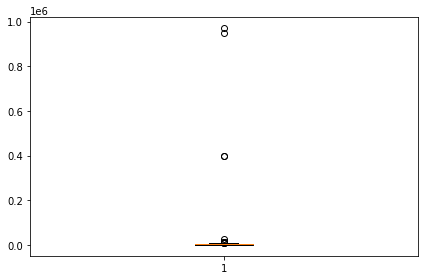

In [ ]:
df_aluguel = df[df['comprar_alugar'] == 'aluguel']
plt.boxplot( x=df_aluguel['preco'] );
plt.tight_layout()

Temos muitos outliers neste grafico.
Talvez o melhor a fazer seja excluidos da base de dados.
Para isso, irei ver quantos registros estao acima do limite superior do nosso boxplot, utilizando a formula:
Limite_Superior = Q3 + 1.5 * (Q3 - Q1)

In [ ]:
q1 = 1800
q3 = 6500

lim_sup = q3 + 1.5*(q3 - q1)

display(df_aluguel[df_aluguel['preco'] > lim_sup])

,comprar_alugar,tipo_imovel,indice,end_completo,bairro,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
50,aluguel,casa_residencial,50,"Rua Júlia Huga Maria Negrello, 291 - Centro, C...",Centro,191.00000,3.00000,3.00000,2.00000,970000.00000,470.00000,0,1
56,aluguel,casa_residencial,56,"Rua Hermes Fontes, 1010 - Batel, Curitiba - PR",Batel,500.00000,4.00000,5.00000,6.00000,15000.00000,0.00000,0,1
59,aluguel,casa_residencial,59,"Rua Guaianazes, 550 - Centro, Curitiba - PR",Centro,250.00000,3.00000,4.00000,4.00000,950000.00000,0.00000,0,1
87,aluguel,condominio_residencial,87,"Alameda das Buganvílias - Mossunguê, Curitiba ...",Mossunguê,700.00000,5.00000,7.00000,3.00000,27000.00000,670.00000,0,1
154,aluguel,flat_residencial,154,"Rua Constantino Marochi, 1342 - Alto da Glória...",Alto da Glória,27.00000,1.00000,1.00000,0.00000,400000.00000,0.00000,0,1
155,aluguel,flat_residencial,155,"Rua Constantino Marochi, 1342 - Alto da Glória...",Alto da Glória,27.00000,1.00000,1.00000,0.00000,400000.00000,0.00000,0,1
234,aluguel,sobrado_residencial,234,Rua Padre Francisco João Azevedo - Jardim Botâ...,Jardi,1440.00000,5.00000,7.00000,6.00000,15000.00000,0.00000,0,1


Como podemos observar, ha imoveis com valores extremamente altos! 
Iremos manter os imoveis com aluguel maximo de R$ 27.000,00.

In [ ]:
df_aluguel = df_aluguel[df_aluguel['preco'] < 27001]
df_aluguel.head()

In [ ]:
df_aluguel.describe()

,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
count,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000,234.00000
mean,142.60256,2.52564,2.30769,1.79915,3505.01282,2313.05556,0.00000,1.00000
std,147.97303,1.26074,1.44104,1.60145,3056.21860,10648.96678,0.00000,0.00000
min,15.00000,0.00000,0.00000,0.00000,450.00000,0.00000,0.00000,1.00000
25%,45.00000,1.00000,1.00000,1.00000,1500.00000,0.00000,0.00000,1.00000
50%,99.50000,3.00000,2.00000,2.00000,2600.00000,300.00000,0.00000,1.00000
75%,184.75000,3.00000,3.00000,2.00000,4475.00000,745.00000,0.00000,1.00000
max,1440.00000,8.00000,7.00000,8.00000,27000.00000,85000.00000,0.00000,1.00000


Agora nosso dataset possui dados mais coerentes com a realidade.
Iremos utiliza-lo para visualizarmos como o preco dos imoveis varia de acordo com suas caracteristicas.

In [ ]:
df_aluguel.groupby('bairro').agg({'preco': ['mean', 'min', 'max', 'std']})

## EDA dividida por tipo de negocio -> VENDA

In [ ]:
df_venda = df[df['comprar_alugar'] == 'venda']

In [ ]:
# EDA dividida por tipo de negocio -> venda
df_venda.describe()

,area_m2,quartos,banheiros,vagas_garagem,preco,condominio,venda,aluguel
count,252.00000,252.00000,252.00000,252.00000,252.00000,252.00000,252.00000,252.00000
mean,140.74603,2.49206,2.61905,1.85317,879935.80556,976.03571,1.00000,0.00000
std,143.67313,1.20917,1.60605,1.72579,1060441.82715,8084.38150,0.00000,0.00000
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
25%,37.50000,1.00000,1.00000,1.00000,274989.75000,0.00000,1.00000,0.00000
50%,114.50000,3.00000,2.00000,2.00000,590000.00000,0.00000,1.00000,0.00000
75%,199.25000,3.00000,3.25000,2.25000,992685.75000,550.00000,1.00000,0.00000
max,1150.00000,8.00000,8.00000,15.00000,8200000.00000,125000.00000,1.00000,0.00000


In [ ]:
q1 = 274989.75
q3 = 992685.75

lim_inf = q1 - 1.5*(q3 - q1)

display(df_venda[df_venda['preco'] > lim_inf])

In [ ]:
df_venda[df_venda['preco'] < 150000]

In [ ]:
# Imoveis p/ vender vs Imoveis p/ alugar

print('Imoveis a Venda vs Imoveis p/ Alugar')
df[['comprar_alugar', 'tipo_imovel']].groupby('comprar_alugar').count()

In [ ]:
# Imoveis por tipo: Aluguel vs Venda

print('Imoveis por tipo: Aluguel vs Venda')
df[['tipo_imovel', 'venda', 'aluguel']].groupby('tipo_imovel').sum()

In [ ]:
df[df['comprar_alugar'] == 'venda'].groupby('tipo_imovel').agg({'preco': ['mean', 'min', 'max', 'std']})